<a href="https://colab.research.google.com/github/Nate-Shubert/FootballDataAnalysis/blob/main/WinPredictionModelAndProbability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Standard Setup, read data saved in google drive.

In [ ]:
# Standard imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = '/content/drive/MyDrive/NFL/CleanDF.csv'
data = pd.read_csv(filepath)

In [ ]:
data.head()

,Unnamed: 0,Tm,W,L,T,W-L%,PF,PA,PD,MoV,...,Def Sc%,Def TO%,Def EXP,Pred Win %,W-L Diff,Exponent,Cmp %,PG Rate,1D per Play,TD per Play
0,0,Arizona Cardinals,11,6,0,0.647,449,366,83,4.9,...,35.6,15.3,-19.46,0.636459,0.010541,2.74,0.702200,7.937394,3.068120,22.520000
1,1,Atlanta Falcons,7,10,0,0.412,313,459,-146,-8.6,...,44.7,11.2,-136.74,0.259417,0.152583,2.74,0.657941,7.137871,3.287582,32.451613
2,2,Baltimore Ravens,8,9,0,0.471,387,392,-5,-0.3,...,34.2,7.9,-107.49,0.491207,0.020207,2.74,0.648118,7.130933,3.007614,30.384615
3,3,Buffalo Bills,11,6,0,0.647,483,289,194,11.4,...,28.0,14.5,36.13,0.803330,0.156330,2.74,0.633588,7.174046,2.871859,20.410714
4,4,Carolina Panthers,5,12,0,0.294,304,404,-100,-5.9,...,37.6,8.1,-9.14,0.314488,0.020488,2.74,0.580968,5.988314,3.434783,35.677419


In [ ]:
#In 2019, average plays per drive was 5.85
data['TD/P'] = (data['Pass TDs'] + data['Rush TD']) / (data['Ply'])
data['1stD/P'] = (data['1stD']) / (data['Ply'])
data['TO/P'] = (data['TO'])/ (data['Ply'])
data['Pen/P'] = (data['Pen Yds'])/ (data['Ply'])
OffTest = data[['PF','Y/P','TO/P','1stD/P','TD/P','Pen/P']]
OffTest.head()

,PF,Y/P,TO/P,1stD/P,TD/P,Pen/P
0,449,5.6,0.013321,0.325933,0.044405,0.879218
1,313,5.1,0.025845,0.304175,0.030815,0.748509
2,387,5.4,0.021941,0.332489,0.032911,0.718987
3,483,5.7,0.019248,0.348206,0.048994,0.857393
4,304,4.6,0.026221,0.291139,0.028029,0.781193


The first part of this project is to relate the number of points a team has scored and allowed to its actual winning percentage. The inspiration for this was taken from Bill James' attempt to do the same with runs in baseball.

In [ ]:
#Functions to Run Pythagorean theorem to predict a Win Percentage based off of points for and against.
def betterDiff(df1,df2):
    sumOne = 0
    sumTwo = 0
    for i in df1:
        sumOne += i
    for j in df2:
        sumTwo += j
    if sumOne > sumTwo:
        return True
    else:
        return False
    
def PythagoreanFootball(givenDF,expArray):
    savedExp = 1
    pointsAgainst = givenDF.loc[:,"PA"]
    pointsFor = givenDF.loc[:,"PF"]
    wlPer = givenDF.loc[:,"W-L%"]
    #Start New Column
    newAbsColumn = [100000,10000011,1000001,10000,10000100]
    newPredictedColumn = [1,1,1,1,1,1,1,1]
    #Fill with rest of data
    for j in expArr:
        tempPredictedColumn = newPredictedColumn
        tempAbsColumn = newAbsColumn
        #Start New Column
        tempPer = theorem(pointsAgainst[0],pointsFor[0],j)
        newPredictedColumn = [tempPer]
        newAbsColumn = [abs(wlPer[0]-tempPer)]
        #Get new Predicted WL% and the difference in actual WL%
        for i in range(1,len(pointsAgainst)):
            tempPer = theorem(pointsAgainst[i],pointsFor[i],j)
            newPredictedColumn.append(tempPer)
            newAbsColumn.append(abs(wlPer[i]-tempPer))
            
        #Check if the new differential is better. If not, keep last data
        if not betterDiff(tempAbsColumn,newAbsColumn):
            newAbsColumn = tempAbsColumn
            newPredictedColumn = tempPredictedColumn
        else:
            savedExp = j
    
    savedExpArr = [savedExp]    
    for i in range(1,len(givenDF)):
        savedExpArr.append(savedExp)
        
    givenDF['Pred Win %'] = newPredictedColumn
    givenDF['W-L Diff'] = newAbsColumn
    givenDF['Exponent'] = savedExpArr
    
    return givenDF

def theorem(pa,pf,ex):
    r = pf/pa
    out = (r**ex)/((r**ex) +1)
    return out

def runPythagoras(df):    
    for i in df:
        i = PythagoreanFootball(i,expArr)
    return df


Using the functions above, I predicted the win-loss percentage of every team in the dataset. I output the average margin of error between my predicted result and the actualt win-loss percentage.

In [ ]:
expArr = [1]
for i in range(1,300):
    deci = i/100
    expArr.append(expArr[0] + deci)
  
AllDF = data.reset_index(drop=True)
AllDF = PythagoreanFootball(AllDF,expArr)
AllDF['Cmp %'] = AllDF['Cmp']/AllDF['Passing Att']
AllDF['PG Rate'] = (AllDF['Cmp'] + AllDF['Pass Yds'])/AllDF['Passing Att']
AllDF['1D per Play'] = AllDF['Ply'] / AllDF['1stD']
AllDF['TD per Play'] = AllDF['Ply'] / (AllDF['Pass TDs'] + AllDF['Rush TD'])

AllDF.to_csv('CleanDF.csv')


winPerSum = AllDF.loc[:,"W-L Diff"]
winPerSum2 = 0
for i in winPerSum:
    winPerSum2 += i
print(winPerSum2/608)

0.06404088337694104


With an error of 6.4%, that roughly equates to 1 regular season NFL game. 

In the previous section, I used two simple variables to predict win percentage. I hope to drill down further in the next section and see if I can break those two variables into more.

0.06404088337694104
Correlation between Ply/PF:  0.4229732700274509
Correlation between Yards per Play/PF:  0.8039212037101358
Correlation between 1stD/PF:  0.7937487424436493
Correlation between TO/PF:  -0.4784420501567737
Correlation between NY/A:PF:  0.8025799945258079
Correlation between Rush Y/A:PF:  0.27748255205377326
Correlation between Cmp%:PF:  0.6005077622536776
Correlation between PG Rate:PF:  0.7880904798788151
Correlation between Offensive Plays/PA:  0.0007114226071722421
Correlation between Defensive Yards per play/PA:  0.7253355401670095
Correlation between Def TO/PA:  -0.44538597593366014


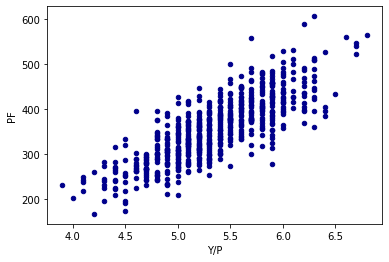

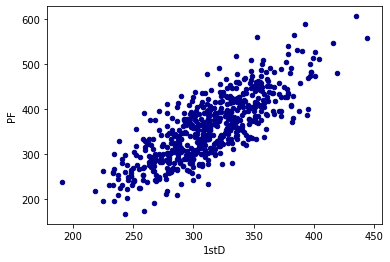

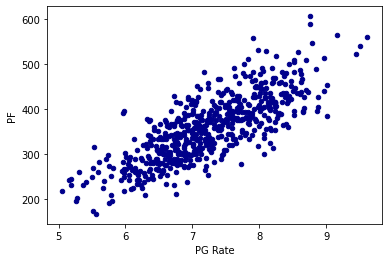

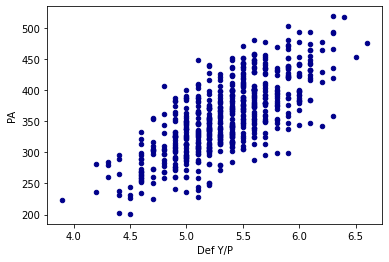

In [ ]:
#Offensive Correlations
#ax1 = AllDF.plot.scatter(x='Ply',y='PF',c='DarkBlue')
c1 = AllDF['Ply'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between Ply/PF:  ' + str(c1))
ax2 = AllDF.plot.scatter(x='Y/P',y='PF',c='DarkBlue')
c2 = AllDF['Y/P'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between Yards per Play/PF:  ' + str(c2))
ax3 = AllDF.plot.scatter(x='1stD',y='PF',c='DarkBlue')
c3 = AllDF['1stD'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between 1stD/PF:  ' + str(c3))
c4 = AllDF['TO'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between TO/PF:  ' + str(c4))

#Specific Offense
c9 = AllDF['NY/A'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between NY/A:PF:  ' + str(c9))
c10 = AllDF['Rush Y/A'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between Rush Y/A:PF:  ' + str(c10))
c11 = AllDF['Cmp %'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between Cmp%:PF:  ' + str(c11))
c12 = AllDF['PG Rate'].astype(float).corr(AllDF['PF'].astype(float))
print('Correlation between PG Rate:PF:  ' + str(c12))
ax4 = AllDF.plot.scatter(x='PG Rate',y='PF',c='DarkBlue')

#Defensive Correlations
c5 = AllDF['Ply'].astype(float).corr(AllDF['PA'].astype(float))
print('Correlation between Offensive Plays/PA:  ' + str(c5))
c6 = AllDF['Def Y/P'].astype(float).corr(AllDF['PA'].astype(float))
print('Correlation between Defensive Yards per play/PA:  ' + str(c6))
ax5 = AllDF.plot.scatter(x='Def Y/P',y='PA',c='DarkBlue')
c7 = AllDF['Def TO'].astype(float).corr(AllDF['PA'].astype(float))
print('Correlation between Def TO/PA:  ' + str(c7))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [ ]:
print(OffTest.head())
print(OffTest.columns)

    PF  Y/P      TO/P    1stD/P      TD/P     Pen/P
0  449  5.6  0.013321  0.325933  0.044405  0.879218
1  313  5.1  0.025845  0.304175  0.030815  0.748509
2  387  5.4  0.021941  0.332489  0.032911  0.718987
3  483  5.7  0.019248  0.348206  0.048994  0.857393
4  304  4.6  0.026221  0.291139  0.028029  0.781193
Index(['PF', 'Y/P', 'TO/P', '1stD/P', 'TD/P', 'Pen/P'], dtype='object')


In [ ]:
c2 = data['Y/P'].astype(float).corr(data['PF'].astype(float))
print(c2)

0.8039212037101358


In [ ]:
c2 = data['TD/P'].astype(float).corr(data['PF'].astype(float))
print(c2)

0.9262954842349076


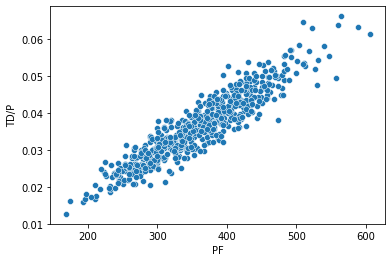

In [ ]:
sns.scatterplot(x='PF',y='TD/P', data=OffTest)

In [ ]:
X = OffTest.drop('PF',axis=1)
Y = OffTest['PF']

After analyzing the correlation between variables in the data set and points for/points against, I was able to find which had significant correlation. Now I hope to put those variables into a linear regression model, and come up with models to predict points for/points against.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=101)

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
predictions = model.predict(X_test)
predictions

array([398.54641448, 311.13899047, 256.9882743 , 426.0399318 ,
       482.33667781, 421.05047423, 401.07007492, 251.50102874,
       270.73949903, 367.32819649, 264.13218597, 379.53311356,
       263.76124225, 353.00621901, 294.53236119, 386.69133246,
       381.6173531 , 299.61437792, 462.07311632, 392.21018016,
       379.85928046, 389.51798892, 276.58663896, 290.46929224,
       381.26653332, 310.09568844, 531.22286343, 447.87209024,
       331.09602703, 360.59537358, 442.9802999 , 413.33335222,
       374.16401852, 353.00697958, 342.15734913, 330.55409847,
       428.7985481 , 386.67501023, 229.65834982, 441.77910985,
       432.63448301, 329.48142537, 286.17340032, 267.41766499,
       382.79688164, 407.01865123, 430.2076378 , 447.88426098,
       372.24944236, 299.43106043, 318.67833057, 346.17415906,
       433.73393808, 274.01015874, 443.07838638, 521.23240121,
       403.74377834, 346.95501989, 455.75260732, 313.82505975,
       325.6808441 , 381.74741108, 258.66073801, 308.78

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score=r2_score(y_test,predictions)
print('r2 score =',score)
print('mean_sqrd_error is=',mean_squared_error(y_test,predictions))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,predictions)))

r2 score = 0.8332709688666908
mean_sqrd_error is= 698.1114264629057
root_mean_squared error of is== 26.421798320002853


In [ ]:
import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     PF   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     810.1
Date:                Fri, 27 Jan 2023   Prob (F-statistic):          1.53e-264
Time:                        16:28:45   Log-Likelihood:                -2846.0
No. Observations:                 608   AIC:                             5704.
Df Residuals:                     602   BIC:                             5730.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.3632     19.669      3.628      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


This regression model shows that the P-Value for Y/P is high which means that in this group of variables it is not strong enough to suggest that an effect exists.

In [ ]:
OffTest = data[['PF','TO/P','1stD/P','TD/P','Pen/P']]
OffTest.head()
X = OffTest.drop('PF',axis=1)
Y = OffTest['PF']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score=r2_score(y_test,predictions)
print('r2 score =',score)
print('mean_sqrd_error is=',mean_squared_error(y_test,predictions))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,predictions)))

r2 score = 0.8323074292032835
mean_sqrd_error is= 702.1458651224638
root_mean_squared error of is== 26.498035118145342


In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     PF   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1010.
Date:                Fri, 27 Jan 2023   Prob (F-statistic):          1.29e-265
Time:                        16:30:18   Log-Likelihood:                -2847.0
No. Observations:                 608   AIC:                             5704.
Df Residuals:                     603   BIC:                             5726.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.2837     18.911      4.192      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


We can confirm that Y/P did not have a significant effect because the R squared value hardly changes when it is taken out of the model.

In [ ]:
OffensiveCoef = model.coef_
OffensiveInt = model.intercept_

In [ ]:
data['Def TD/P'] = (data['Def Pass TDs'] + data['Def Rush TD']) / (data['Def Ply'])
data['Def 1stD/P'] = (data['Def 1stD']) / (data['Def Ply'])
data['Def TO/P'] = (data['Def TO'])/ (data['Def Ply'])
data['Def Pen/P'] = (data['Def Pen']*data['Def Pen Yds'])/ (data['Def Ply'])
DefTest = data[['PA','Def Y/P','Def TO/P','Def 1stD/P','Def TD/P','Def Pen/P']]
DefTest.head()
X = DefTest.drop('PA',axis=1)
Y = DefTest['PA']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=101)
model2 = LinearRegression()
model2.fit(X_train,y_train)
predictions = model2.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score=r2_score(y_test,predictions)
print('r2 score =',score)
print('mean_sqrd_error is=',mean_squared_error(y_test,predictions))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,predictions)))

r2 score = 0.812483847427378
mean_sqrd_error is= 660.9080735794201
root_mean_squared error of is== 25.70813244052201


In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     PA   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     551.3
Date:                Fri, 27 Jan 2023   Prob (F-statistic):          5.69e-222
Time:                        16:30:24   Log-Likelihood:                -2817.1
No. Observations:                 608   AIC:                             5646.
Df Residuals:                     602   BIC:                             5673.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.4570     18.917      4.940      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


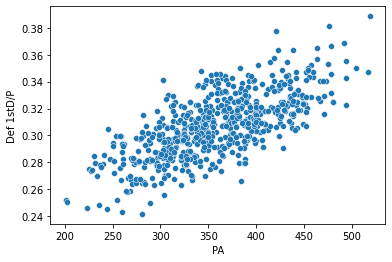

In [ ]:
sns.scatterplot(x='PA',y='Def 1stD/P', data=DefTest)

In [ ]:
DefTest = data[['PA','Def Y/P','Def TO/P','Def TD/P','Def Pen/P']]
DefTest.head()
X = DefTest.drop('PA',axis=1)
Y = DefTest['PA']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=101)
model2 = LinearRegression()
model2.fit(X_train,y_train)
predictions = model2.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score=r2_score(y_test,predictions)
print('r2 score =',score)
print('mean_sqrd_error is=',mean_squared_error(y_test,predictions))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,predictions)))

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     PA   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     690.2
Date:                Fri, 27 Jan 2023   Prob (F-statistic):          2.09e-223
Time:                        16:30:32   Log-Likelihood:                -2817.1
No. Observations:                 608   AIC:                             5644.
Df Residuals:                     603   BIC:                             5666.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.2861     16.462      5.545      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
DefensiveCoef = model2.coef_
DefensiveInt = model2.intercept_

In [ ]:
print(DefensiveCoef)

[ 1.84767280e+01 -1.41016449e+03  5.91886829e+03 -9.70015526e-02]


In [ ]:
DefensiveInt

86.99586220484514

In [ ]:
DefTest.head()

,PA,Def Y/P,Def TO/P,Def TD/P,Def Pen/P
0,366,5.4,0.026265,0.038911,87.159533
1,459,5.6,0.017953,0.044883,101.263914
2,392,6.0,0.014521,0.042594,83.674734
3,289,4.6,0.029586,0.030572,84.899408
4,404,5.1,0.015564,0.040856,94.132296


In [ ]:

def PFEquation(OffArr,OffDF,OffCoef):
  outArr = []
  for i in OffTest.index:
    tempOut = OffCoef + (OffArr[0]*OffTest['TO/P'][i]) + (OffArr[1]*OffTest['1stD/P'][i]) +  (OffArr[2]*OffTest['TD/P'][i]) + (OffArr[3]*OffTest['Pen/P'][i])
    outArr.append(tempOut)
  return outArr

In [ ]:
def PAEquation(DefArr,DefDF,DefInt):
  outArr = []
  for i in OffTest.index:
    tempOut = DefInt + (DefArr[0]*DefTest['Def Y/P'][i]) + (DefArr[1]*DefTest['Def TO/P'][i]) +  (DefArr[2]*DefTest['Def TD/P'][i]) + (DefArr[3]*DefTest['Def Pen/P'][i])
    outArr.append(tempOut)
  return outArr

In [ ]:
data['Projected PF'] = PFEquation(OffensiveCoef,OffTest,OffensiveInt)
data['Projected PA'] = PAEquation(DefensiveCoef,DefTest,DefensiveInt)

In [ ]:
r = data['Projected PF'] / data['Projected PA']
data['Projected Win %'] = (r**2)/((r**2) +1)
data['Projected Win Diff'] = abs(data['W-L%'] - data['Projected Win %'])
data['Projected PA Diff'] = abs(data['PA'] - data['Projected PA'])
data['Projected PF Diff'] = abs(data['PF'] - data['Projected PF'])

In [ ]:
ProjWinDiffMean = data['Projected Win Diff'].mean()
print("New Projected Win-Loss % Error: "+ str(ProjWinDiffMean))
ProjPAMean = data['Projected PA Diff'].mean() / data['PA'].mean()
print("New Projected Points Allowed % Error: "+ str(ProjPAMean))
ProjPFMean = data['Projected PF Diff'].mean()/ data['PF'].mean()
print("New Projected Points For % Error: "+ str(ProjPFMean))

New Projected Win-Loss % Error: 0.09101587822813692
New Projected Points Allowed % Error: 0.05601392752892514
New Projected Points For % Error: 0.05733806598675818


With an error of 9.1%, that roughly equates to 1-1/2 regular season NFL game. Not as good as our pythagorean model.

However, using linear regression for Points Allowed and Points For gave us respective functions that were able to predict within ~5.65% error. That equates to around 20 points over the course of a season, or just 1.17 points per game.

**Using Distribution Methods to predict the probability of events occuring**

The third part of this project is to come up with probability and distribution for given variables that can be associate specifically with a 10 win team (58.82 win %), which has been a guaranteed win threshhold for a playoff team since the league moved to a 17 game season.

Use Poisson Distribution to find the probability of a certain number of teams per season having point differentials above average values for a top 16 team, top 14 team (playoff caliber), and top 8 team.

In [ ]:
import math

def poissonDist(k,lam):
  euler = 2.71828
  num = (lam ** k) * (euler ** (-lam))
  den = math.factorial(k)
  return num/den
  

In [ ]:
quantArr = data.PD.quantile([0.5,0.5625,0.75])

In [ ]:
data.columns

Index(['Unnamed: 0', 'Tm', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV',
       'SoS', 'SRS', 'OSRS', 'DSRS', 'Rk', 'G', 'Off Yds', 'Ply', 'Y/P', 'TO',
       'Fl', '1stD', 'Cmp', 'Passing Att', 'Pass Yds', 'Pass TDs', 'Int',
       'NY/A', 'Pass 1stD', 'Rush Att', 'Rush Yds', 'Rush TD', 'Rush Y/A',
       'Rush 1stD', 'Pen', 'Pen Yds', 'Pen 1stPy', 'Sc%', 'TO%', 'EXP',
       'Def Yds', 'Def Ply', 'Def Y/P', 'Def TO', 'Def Fl', 'Def 1stD',
       'Def Cmp', 'Def Passing Att', 'Def Pass Yds', 'Def Pass TDs', 'Def Int',
       'Def NY/A', 'Def Pass 1stD', 'Def Rush Att', 'Def Rush Yds',
       'Def Rush TD', 'Def Rush Y/A', 'Def Rush 1stD', 'Def Pen',
       'Def Pen Yds', 'Def Pen 1stPy', 'Def Sc%', 'Def TO%', 'Def EXP',
       'Pred Win %', 'W-L Diff', 'Exponent', 'Cmp %', 'PG Rate', '1D per Play',
       'TD per Play', 'TD/P', '1stD/P', 'TO/P', 'Pen/P', 'Projected PF',
       'Projected PA', 'Projected Win %', 'Projected Win Diff',
       'Projected PA Diff', 'Projected PF Diff'],


In [ ]:
data2 = data.rename(columns={"Y/P": "YperP","Def Y/P": "DYperP","W-L%":"WinLossPer"})

In [ ]:
#Average top 14 team values for PF and PA.
pf = data2.PF.quantile([0.5625])
pa = data2.PA.quantile([0.4375])
pf = pf.iloc[0]
pa = pa.iloc[0]

pfCount = 0
paCount = 0
for i in range(0,len(data)):
  if data2['PF'][i] >= pf:
    pfCount += 1
  if data2['PA'][i] <= pa:
    paCount += 1


In [ ]:
median = quantArr.iloc[0]
playoffQuantile = quantArr.iloc[1]
thirdQuantile = quantArr.iloc[2]

In [ ]:
medCount = 0
thirdCount = 0
playoffCount = 0
numSeasons = 0
for i in range(0,len(data)):
  if data['Tm'][i] == 'Buffalo Bills':
    numSeasons += 1
  if data['PD'][i] >= median:
    medCount += 1
    if data['PD'][i] >= playoffQuantile:
      playoffCount += 1
      if data['PD'][i] >= thirdQuantile:
        thirdCount += 1

In [ ]:
medCount = medCount / numSeasons
thirdCount = thirdCount / numSeasons
playoffCount = playoffCount / numSeasons
ypaCount = pfCount / numSeasons
dypaCount = paCount / numSeasons

In [ ]:
medArr = []
pfArr = []
playoffArr = []
thirdArr = []
paArr = []
for i in range(0,32):
  medArr.append(poissonDist(i,medCount))
  thirdArr.append(poissonDist(i,thirdCount))
  playoffArr.append(poissonDist(i,playoffCount))
  pfArr.append(poissonDist(i,ypaCount))
  paArr.append(poissonDist(i,dypaCount))

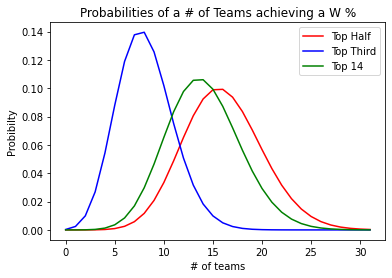

In [ ]:
 
# data to be plotted
y = np.array(medArr)
x = np.arange(0,32)
y2 = np.array(thirdArr)
y3 = np.array(playoffArr)
 
# plotting
plt.title("Probabilities of a # of Teams achieving a W %")
plt.xlabel("# of teams")
plt.ylabel("Probibilty")
plt.plot(x, y, label ="Top Half",color ="red")
plt.plot(x, y2, label ="Top Third", color ="blue")
plt.plot(x, y3, label ="Top 14", color ="green")

plt.legend()
plt.show()

Nest, I use conditional probability to find the probability of a team having 10 wins given a set of variables.

In [ ]:
#Constant probability of a team being in the top 14 on a per season basis.
constantProb = 14/32

In [ ]:
#Using the dataset, find how often cases occur where the Point Differential, Points Allowed, and Points For are in the top 14 and they have 10 wins.
pdCount = 0
paCount = 0
pfCount = 0
for i in range(0,len(data2)):
  if data2['PD'][i] >= playoffQuantile and data2['WinLossPer'][i] >= 0.58:
    pdCount += 1
  if data2['PA'][i] <= pa and data2['WinLossPer'][i] >= 0.58:
    paCount += 1
  if data2['PF'][i] >= pf and data2['WinLossPer'][i] >= 0.58:
    pfCount += 1
pdCount = pdCount/len(data2)
paCount = paCount/len(data2)
pfCount = pfCount/len(data2)

In [ ]:
# Conditional Probability that a team will have 10 wins if it has a top 14 Point Differential.
conProbOne = pdCount / constantProb
conProbOne

0.7518796992481204

In [ ]:
# Conditional Probability that a team will have 10 wins if it has a top 14 Points For.
conProbTwo = pfCount / constantProb
conProbTwo

0.650375939849624

In [ ]:
# Conditional Probability that a team will have 10 wins if it has a top 14 Points Allowed.
conProbThree = paCount / constantProb
conProbThree

0.5977443609022556

In [ ]:
denCount = 0
numCount = 0
for i in range(0,len(data2)):
  if data2['PD'][i] >= playoffQuantile and data2['WinLossPer'][i] >= 0.58 and data2['PF'][i] >= pf:
    numCount += 1
  if data2['PD'][i] >= playoffQuantile and data2['PF'][i] >=pf:
    denCount += 1

denCount = denCount / len(data2)
numCount = numCount / len(data2)
conProbFour = numCount / denCount

In [ ]:
# Probability that a team will have 10 wins and top 14 in Point Differential and Points For.
conProbFour

0.8203883495145631

In [ ]:
denCount = 0
numCount = 0
for i in range(0,len(data2)):
  if data2['PD'][i] >= playoffQuantile and data2['WinLossPer'][i] >= 0.58 and data2['PA'][i] <= pa:
    numCount += 1
  if data2['PD'][i] >= playoffQuantile and data2['PA'][i] <= pa:
    denCount += 1

denCount = denCount / len(data2)
numCount = numCount / len(data2)
conProbFive = numCount / denCount

In [ ]:
# Probability that a team will have 10 wins and top 14 in Point Differential and Points Against.
conProbFive

0.7857142857142857

In [ ]:
denCount = 0
numCount = 0
for i in range(0,len(data2)):
  if data2['PD'][i] >= playoffQuantile and data2['WinLossPer'][i] >= 0.58 and data2['PF'][i] >= pf and data2['PA'][i] <= pa:
    numCount += 1
  if data2['PD'][i] >= playoffQuantile and data2['PF'][i] >= pf and data2['PA'][i] <= pa:
    denCount += 1

denCount = denCount / len(data2)
numCount = numCount / len(data2)
conProbSix = numCount / denCount

In [ ]:
# Probability that a team will have 10 wins and top 14 in Point Differential, Points For and Points Against.
conProbSix

0.8978102189781022

The following is the determined chance of a team having a 10 win season with these conditions:


*   Top 14 Team in Point Differential - **75.2%**
*   Top 14 Team in Points Allowed - **65.0%**
*   Top 14 Team in Points For - **59.8%**
*   Top 14 Team in Point Differential & Points Allowed - **78.6%**
*   Top 14 Team in Point Differential & Points For - **82.0%**
*   Top 14 Team in Point Differential, Points Allowed & Points For - **89.8%**